In [31]:
import math
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [8]:
df = yf.download('BTC-USD', start='2020-05-24', end='2024-06-02')

[*********************100%%**********************]  1 of 1 completed


In [13]:
df = df[['Close']].dropna()
df['Prev_Close'] = df['Close'].shift(1)
df = df.dropna()
x = df[['Prev_Close']]
y = df['Close']

In [15]:
x

,Prev_Close
Date,
2020-05-26,8906.934570
2020-05-27,8835.052734
2020-05-28,9181.017578
2020-05-29,9525.750977
2020-05-30,9439.124023
...,...
2024-05-27,68518.093750
2024-05-28,69394.554688
2024-05-29,68296.218750


In [16]:
y

Date
2020-05-26     8835.052734
2020-05-27     9181.017578
2020-05-28     9525.750977
2020-05-29     9439.124023
2020-05-30     9700.414062
                  ...     
2024-05-27    69394.554688
2024-05-28    68296.218750
2024-05-29    67578.093750
2024-05-30    68364.992188
2024-05-31    67491.414062
Name: Close, Length: 1467, dtype: float64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [19]:
#Grid search
#I'll be changing this with catboost's grid_search next time.
param_grid = {
    'iterations': [1000, 2000, 3000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [2, 4, 6, 8]
}

grid_search = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE', verbose=100),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best CV score: ", -grid_search.best_score_)

0:	learn: 11549.3471435	total: 136ms	remaining: 2m 16s
100:	learn: 1174.1075821	total: 155ms	remaining: 1.38s
200:	learn: 1101.4524546	total: 172ms	remaining: 683ms
300:	learn: 1065.9329134	total: 190ms	remaining: 441ms
400:	learn: 1046.5796357	total: 208ms	remaining: 311ms
500:	learn: 1035.1227760	total: 226ms	remaining: 225ms
600:	learn: 1024.6695394	total: 243ms	remaining: 162ms
700:	learn: 1016.4300945	total: 264ms	remaining: 113ms
800:	learn: 1009.9315893	total: 288ms	remaining: 71.5ms
900:	learn: 1005.0746965	total: 309ms	remaining: 33.9ms
999:	learn: 1000.3456310	total: 326ms	remaining: 0us
0:	learn: 12315.2737905	total: 280us	remaining: 280ms
100:	learn: 1187.6739415	total: 19.1ms	remaining: 170ms
200:	learn: 1071.0379697	total: 37ms	remaining: 147ms
300:	learn: 1020.1889853	total: 54.5ms	remaining: 127ms
400:	learn: 995.9220863	total: 73.9ms	remaining: 110ms
500:	learn: 980.2106047	total: 93.4ms	remaining: 93ms
600:	learn: 969.7377793	total: 114ms	remaining: 75.4ms
700:	learn:

In [21]:
model = CatBoostRegressor(iterations= 1000, learning_rate= 0.01, depth= 4)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 14681.2784500	test: 21485.3408535	best: 21485.3408535 (0)	total: 484us	remaining: 484ms
1:	learn: 14546.5666213	test: 21333.5843301	best: 21333.5843301 (1)	total: 918us	remaining: 458ms
2:	learn: 14414.4663232	test: 21175.7480023	best: 21175.7480023 (2)	total: 1.32ms	remaining: 439ms
3:	learn: 14283.8731129	test: 21021.0652754	best: 21021.0652754 (3)	total: 1.7ms	remaining: 423ms
4:	learn: 14150.7181943	test: 20858.9871309	best: 20858.9871309 (4)	total: 2.09ms	remaining: 415ms
5:	learn: 14022.0832746	test: 20702.8676658	best: 20702.8676658 (5)	total: 2.46ms	remaining: 408ms
6:	learn: 13895.4677184	test: 20564.5322609	best: 20564.5322609 (6)	total: 2.85ms	remaining: 404ms
7:	learn: 13769.0067673	test: 20416.1136249	best: 20416.1136249 (7)	total: 3.23ms	remaining: 401ms
8:	learn: 13650.6209767	test: 20298.9662144	best: 20298.9662144 (8)	total: 3.62ms	remaining: 398ms
9:	learn: 13529.8809401	test: 20166.9920782	best: 20166.9920782 (9)	total: 4ms	remaining: 396ms
10:	learn: 13405

In [32]:
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
print(f"Mean Squared Error: {mse}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, pred))}")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, pred)}")

Mean Squared Error: 5450537.324554248
RMSE: 2334.6385854247865
MAE: 1442.748661178545
MAPE: 0.026257681745156202


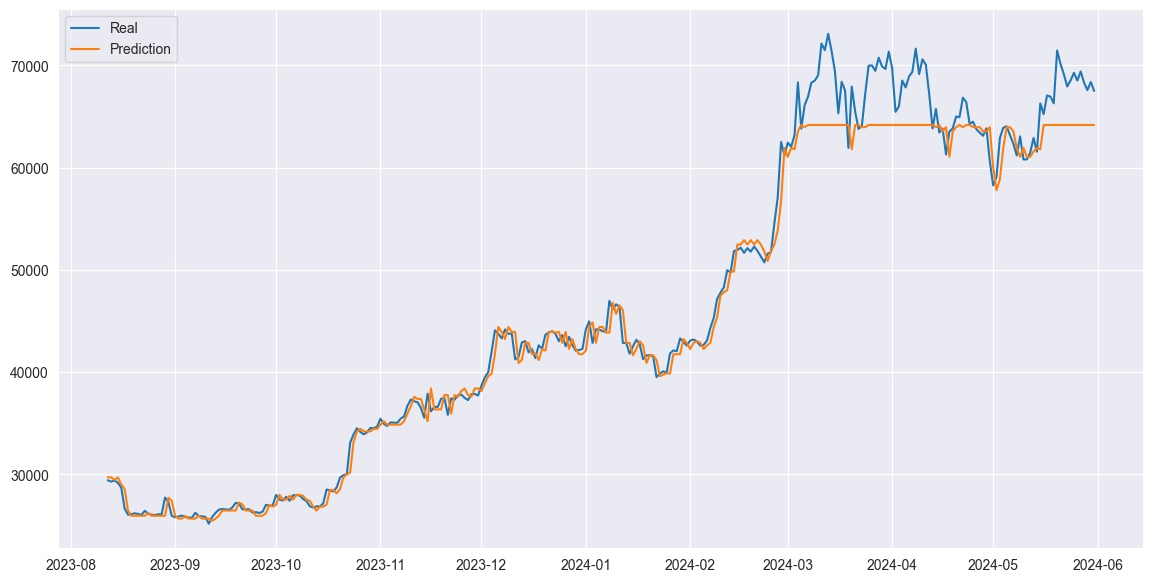

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, pred, label='Prediction')
plt.legend()
plt.show()
